# Big Data Bowl 2026 - Phase 3: Air Play IQ Metrics

## Overview

This notebook combines outputs from Phase 1 (route modeling) and Phase 2 (post-throw convergence) to create intuitive, coach-friendly metrics:

1. **RouteExecIQ**: How well did the WR execute their route (pre-throw)?
2. **ConvergenceIQ_WR**: How efficiently did the WR track the ball (post-throw)?
3. **AirPlayIQ_WR**: Overall WR performance combining both components

**Data Sources**:
- `wr_routes_embeddings.csv` (Phase 1 output)
- `postthrow_predictions.csv` (Phase 2 output)
- `supplementary_data.csv` (original data)

---

## Setup

In [108]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Data

In [109]:
# File paths
data_dir = r"C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl"
routes_path = f"{data_dir}\\wr_routes_embeddings.csv"
predictions_path = f"{data_dir}\\postthrow_predictions_Completed_Pass.csv"
supp_path = f"{data_dir}\\supplementary_data.csv"

print("Loading data...")
df_routes = pd.read_csv(routes_path)
df_predictions = pd.read_csv(predictions_path)
df_supp = pd.read_csv(supp_path)

print(f"\nData loaded!")
print(f"  Routes: {df_routes.shape}")
print(f"  Predictions: {df_predictions.shape}")
print(f"  Supplementary: {df_supp.shape}")

Loading data...

Data loaded!
  Routes: (8202, 26)
  Predictions: (53785, 6)
  Supplementary: (18009, 41)


In [110]:
# Preview data
print("Route embeddings columns:")
print(df_routes.columns.tolist()[:15], "...")

print("\nPredictions columns:")
print(df_predictions.columns.tolist())

print("\nSample route data:")
df_routes.head()

Route embeddings columns:
['game_id', 'play_id', 'nfl_id', 'player_name', 'player_position', 'route_embed_1', 'route_embed_2', 'route_embed_3', 'route_embed_4', 'route_embed_5', 'route_embed_6', 'route_embed_7', 'route_embed_8', 'route_embed_9', 'route_embed_10'] ...

Predictions columns:
['game_id', 'play_id', 'frame_id', 'actual_converge_rate', 'predicted_converge_rate', 'residual']

Sample route data:


,game_id,play_id,nfl_id,player_name,player_position,route_embed_1,route_embed_2,route_embed_3,route_embed_4,route_embed_5,route_embed_6,route_embed_7,route_embed_8,route_embed_9,route_embed_10,route_embed_11,route_embed_12,route_embed_13,route_embed_14,route_embed_15,pass_result,route_label,yards_gained,expected_points_added,route_cluster,pass_result_num
0,2023090700,101,44930,Josh Reynolds,WR,11.773586,11.40,1.97,52.43,14.14,7.90,4.611154,2.936111,5.56,2.975769,2,26,2.5,2.20,0.982620,I,CORNER,0,-2.145443,5,1
1,2023090700,361,38696,Marvin Jones,WR,17.888180,13.54,10.43,34.19,48.33,6.78,3.500980,2.358838,5.71,2.765490,1,51,5.0,10.45,0.955459,C,HITCH,5,-0.862062,3,0
2,2023090700,436,53541,Amon-Ra St. Brown,WR,4.892001,4.21,1.88,33.67,37.80,4.43,2.512000,1.666558,6.25,3.491500,2,20,1.9,2.05,0.942497,C,SLANT,13,1.613927,4,0
3,2023090700,461,44930,Josh Reynolds,WR,9.427876,8.95,2.54,51.82,13.98,6.89,4.187391,2.678596,6.49,3.649130,1,23,2.2,2.62,0.986802,C,POST,21,1.345633,5,0
4,2023090700,530,53541,Amon-Ra St. Brown,WR,4.804947,4.19,2.07,89.25,17.22,4.14,2.434500,1.704343,4.08,2.512000,2,20,1.9,2.07,0.972630,C,OUT,5,0.031384,10,0


---

## 3.1 Route Execution Score (RouteExecIQ)

**Approach**: Measure deviation from route cluster centroid.

**Steps**:
1. Calculate centroid (mean) for each route cluster
2. Compute Euclidean distance from centroid for each play
3. Standardize within cluster to create RouteExecIQ

**Interpretation**:
- RouteExecIQ > 0: Route was cleaner/more efficient than average
- RouteExecIQ < 0: Route had more deviation/wasted movement

---

### Step 1: Define Route Features for Comparison

In [111]:
# Key route features to use for centroid calculation
route_feature_cols = [
    'route_embed_1',   # route_distance
    'route_embed_2',   # route_depth  
    'route_embed_3',   # route_width
    'route_embed_6',   # max_speed
    'route_embed_7',   # avg_speed
    'route_embed_11',  # direction_changes
    'route_embed_15'   # route_efficiency
]

print(f"Using {len(route_feature_cols)} route features for RouteExecIQ calculation")
print(f"Features: {route_feature_cols}")

Using 7 route features for RouteExecIQ calculation
Features: ['route_embed_1', 'route_embed_2', 'route_embed_3', 'route_embed_6', 'route_embed_7', 'route_embed_11', 'route_embed_15']


### Step 2: Calculate Cluster Centroids

In [112]:
# Calculate centroid for each route cluster
print("Calculating route cluster centroids...")

cluster_centroids = df_routes.groupby('route_cluster')[route_feature_cols].mean()

print(f"\nCentroids calculated for {len(cluster_centroids)} clusters")
print(f"\nSample centroid (Cluster 0):")
print(cluster_centroids.iloc[0])

Calculating route cluster centroids...

Centroids calculated for 12 clusters

Sample centroid (Cluster 0):
route_embed_1     21.385009
route_embed_2     19.537184
route_embed_3      4.945021
route_embed_6      8.317642
route_embed_7      5.652873
route_embed_11     0.367545
route_embed_15     0.956745
Name: 0, dtype: float64


### Step 3: Calculate Deviation from Centroid

In [113]:
# Calculate deviation for each route
print("Calculating route deviations from cluster centroids...")

def calculate_route_deviation(row, centroids):
    """Calculate Euclidean distance from route to its cluster centroid."""
    cluster_id = row['route_cluster']
    centroid = centroids.loc[cluster_id].values
    route_features = row[route_feature_cols].values
    
    deviation = euclidean(route_features, centroid)
    return deviation

df_routes['route_deviation'] = df_routes.apply(
    lambda row: calculate_route_deviation(row, cluster_centroids), 
    axis=1
)

print(f"\nRoute deviations calculated!")
print(f"  Mean deviation: {df_routes['route_deviation'].mean():.3f}")
print(f"  Median deviation: {df_routes['route_deviation'].median():.3f}")
print(f"  Std deviation: {df_routes['route_deviation'].std():.3f}")

Calculating route deviations from cluster centroids...

Route deviations calculated!
  Mean deviation: 4.032
  Median deviation: 3.424
  Std deviation: 2.678


### Step 4: Standardize to RouteExecIQ

In [114]:
# Standardize within each route cluster
print("Standardizing to RouteExecIQ...")

def standardize_within_cluster(group):
    """Standardize deviation within cluster to create IQ score."""
    mean_dev = group['route_deviation'].mean()
    std_dev = group['route_deviation'].std()
    
    # RouteExecIQ = negative of standardized deviation
    # (lower deviation = better = positive IQ)
    group['RouteExecIQ'] = -(group['route_deviation'] - mean_dev) / std_dev
    
    return group

df_routes = df_routes.groupby('route_cluster', group_keys=False).apply(standardize_within_cluster)

print(f"\nRouteExecIQ calculated!")
print(f"  Mean: {df_routes['RouteExecIQ'].mean():.3f} (should be ~0)")
print(f"  Std: {df_routes['RouteExecIQ'].std():.3f} (should be ~1)")
print(f"  Min: {df_routes['RouteExecIQ'].min():.2f}")
print(f"  Max: {df_routes['RouteExecIQ'].max():.2f}")

Standardizing to RouteExecIQ...

RouteExecIQ calculated!
  Mean: -0.000 (should be ~0)
  Std: 0.999 (should be ~1)
  Min: -10.43
  Max: 2.00


### Step 5: Visualize RouteExecIQ Distribution

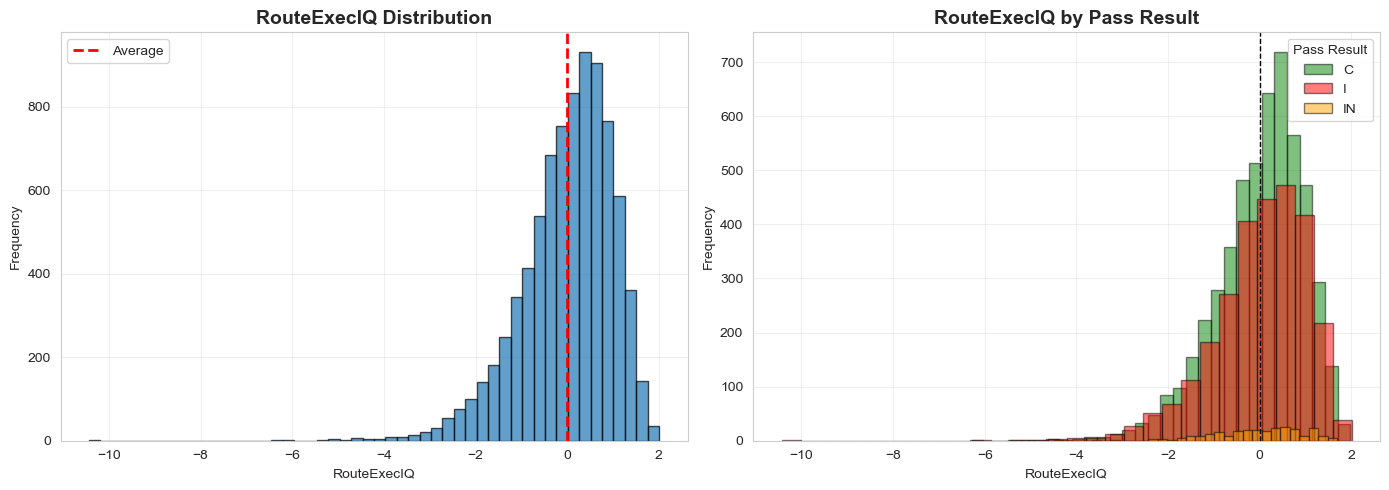


RouteExecIQ by pass result:
                 mean       std  count
pass_result                           
C            0.006267  0.975873   5199
I           -0.007912  1.041496   2744
IN          -0.041989  1.010772    259


In [115]:
# Visualize RouteExecIQ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(df_routes['RouteExecIQ'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Average')
axes[0].set_title('RouteExecIQ Distribution', fontweight='bold', fontsize=14)
axes[0].set_xlabel('RouteExecIQ')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# By pass result
for result, color in [('C', 'green'), ('I', 'red'), ('IN', 'orange')]:
    subset = df_routes[df_routes['pass_result'] == result]['RouteExecIQ']
    axes[1].hist(subset, bins=30, alpha=0.5, label=result, color=color, edgecolor='black')

axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('RouteExecIQ by Pass Result', fontweight='bold', fontsize=14)
axes[1].set_xlabel('RouteExecIQ')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Pass Result')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Stats by pass result
print("\nRouteExecIQ by pass result:")
print(df_routes.groupby('pass_result')['RouteExecIQ'].agg(['mean', 'std', 'count']))

---

## 3.2 Convergence IQ (ConvergenceIQ_WR)

**Approach**: LSTM residual-based scoring with contextual standardization.

**Steps**:
1. Calculate frame-level residual: actual - predicted convergence
2. Define context groups (route cluster + air yards)
3. Standardize residuals within context
4. Aggregate to play-level score

**Interpretation**:
- ConvergenceIQ > 0: WR tracked ball better than expected
- ConvergenceIQ < 0: WR tracked ball worse than expected

---

### Step 1: Calculate Frame-Level Residuals

In [116]:
# Frame-level IQ (residual)
print("Calculating frame-level convergence residuals...")

df_predictions['IQ_frame_raw'] = df_predictions['actual_converge_rate'] - df_predictions['predicted_converge_rate']

print(f"\nFrame-level residuals calculated!")
print(f"  Mean: {df_predictions['IQ_frame_raw'].mean():.4f} (should be ~0)")
print(f"  Std: {df_predictions['IQ_frame_raw'].std():.4f}")
print(f"  Positive (better than expected): {(df_predictions['IQ_frame_raw'] > 0).sum()} frames")
print(f"  Negative (worse than expected): {(df_predictions['IQ_frame_raw'] < 0).sum()} frames")

Calculating frame-level convergence residuals...

Frame-level residuals calculated!
  Mean: 0.0055 (should be ~0)
  Std: 0.0784
  Positive (better than expected): 32385 frames
  Negative (worse than expected): 21400 frames


### Step 2: Add Context Variables

In [117]:
# Merge context from routes data
print("Adding context variables...")

context_cols = ['game_id', 'play_id', 'route_cluster']
df_predictions = df_predictions.merge(
    df_routes[context_cols],
    on=['game_id', 'play_id'],
    how='left'
)

# Add air yards from supplementary data
df_predictions = df_predictions.merge(
    df_supp[['game_id', 'play_id', 'pass_length']].rename(columns={'pass_length': 'air_yards'}),
    on=['game_id', 'play_id'],
    how='left'
)

# Create air yards bins
df_predictions['air_yards_bin'] = pd.cut(
    df_predictions['air_yards'],
    bins=[0, 10, 20, 30, 100],
    labels=['0-10', '10-20', '20-30', '30+']
)

print(f"\nContext variables added!")
print(f"  Route clusters: {df_predictions['route_cluster'].nunique()}")
print(f"  Air yards bins: {df_predictions['air_yards_bin'].value_counts().to_dict()}")

Adding context variables...

Context variables added!
  Route clusters: 12
  Air yards bins: {'0-10': 26086, '10-20': 16742, '20-30': 6041, '30+': 4254}


### Step 3: Standardize Within Context Groups

In [118]:
# Standardize residuals within context groups
print("Standardizing residuals within context...")

def standardize_residuals(group, min_samples=30):
    """Standardize residuals within context group."""
    if len(group) >= min_samples:
        std = group['IQ_frame_raw'].std()
        if std > 0:
            group['IQ_frame'] = group['IQ_frame_raw'] / std
        else:
            group['IQ_frame'] = group['IQ_frame_raw']
    else:
        # Use global std for small groups
        global_std = df_predictions['IQ_frame_raw'].std()
        group['IQ_frame'] = group['IQ_frame_raw'] / global_std
    
    return group

# Standardize within route_cluster + air_yards_bin
df_predictions = df_predictions.groupby(
    ['route_cluster', 'air_yards_bin'], 
    group_keys=False
).apply(standardize_residuals)

print(f"\nStandardization complete!")
print(f"  IQ_frame mean: {df_predictions['IQ_frame'].mean():.4f}")
print(f"  IQ_frame std: {df_predictions['IQ_frame'].std():.4f}")

Standardizing residuals within context...

Standardization complete!
  IQ_frame mean: 0.0830
  IQ_frame std: 1.0139


### Step 4: Aggregate to Play-Level ConvergenceIQ

In [119]:
# Aggregate to play level with weighted average (emphasize later frames)
print("Aggregating to play-level ConvergenceIQ...")

def aggregate_convergence_iq(group):
    """Aggregate frame-level IQ to play-level with weighting."""
    n_frames = len(group)
    
    # Weight later frames more heavily (ball arriving)
    weights = np.linspace(0.5, 1.5, n_frames)
    
    # Weighted average
    convergence_iq = np.average(group['IQ_frame'], weights=weights)
    
    return pd.Series({
        'ConvergenceIQ_WR': convergence_iq,
        'mean_IQ_frame': group['IQ_frame'].mean(),
        'num_frames': n_frames
    })

convergence_by_play = df_predictions.groupby(['game_id', 'play_id']).apply(aggregate_convergence_iq).reset_index()

print(f"\nConvergenceIQ_WR calculated for {len(convergence_by_play)} plays!")
print(f"  Mean: {convergence_by_play['ConvergenceIQ_WR'].mean():.3f}")
print(f"  Std: {convergence_by_play['ConvergenceIQ_WR'].std():.3f}")
print(f"  Min: {convergence_by_play['ConvergenceIQ_WR'].min():.2f}")
print(f"  Max: {convergence_by_play['ConvergenceIQ_WR'].max():.2f}")

Aggregating to play-level ConvergenceIQ...

ConvergenceIQ_WR calculated for 5105 plays!
  Mean: 0.079
  Std: 0.648
  Min: -6.13
  Max: 2.14


### Step 5: Visualize ConvergenceIQ

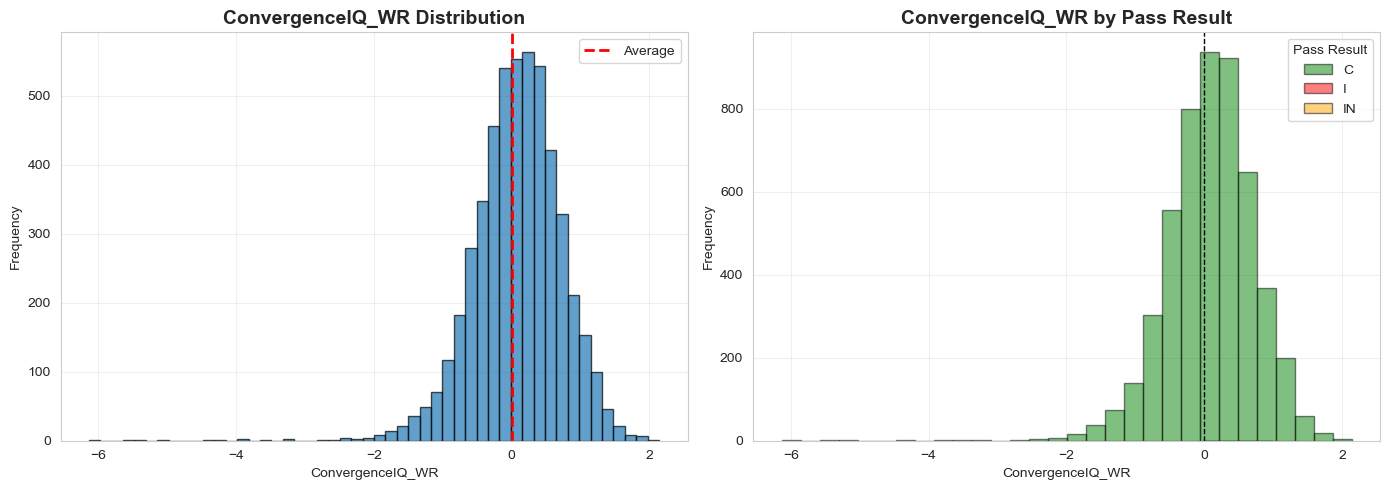


ConvergenceIQ_WR by pass result:
                 mean       std  count
pass_result                           
C            0.079034  0.647573   5105


In [120]:
# Merge with pass result for visualization
convergence_viz = convergence_by_play.merge(
    df_routes[['game_id', 'play_id', 'pass_result']],
    on=['game_id', 'play_id'],
    how='left'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(convergence_by_play['ConvergenceIQ_WR'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Average')
axes[0].set_title('ConvergenceIQ_WR Distribution', fontweight='bold', fontsize=14)
axes[0].set_xlabel('ConvergenceIQ_WR')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# By pass result
for result, color in [('C', 'green'), ('I', 'red'), ('IN', 'orange')]:
    subset = convergence_viz[convergence_viz['pass_result'] == result]['ConvergenceIQ_WR']
    axes[1].hist(subset, bins=30, alpha=0.5, label=result, color=color, edgecolor='black')

axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('ConvergenceIQ_WR by Pass Result', fontweight='bold', fontsize=14)
axes[1].set_xlabel('ConvergenceIQ_WR')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Pass Result')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Stats by pass result
print("\nConvergenceIQ_WR by pass result:")
print(convergence_viz.groupby('pass_result')['ConvergenceIQ_WR'].agg(['mean', 'std', 'count']))

---

## 3.3 Combined Air Play IQ

**Formula**: `AirPlayIQ_WR = 0.5 * RouteExecIQ + 0.5 * ConvergenceIQ_WR`

Combines:
- Pre-throw route quality (RouteExecIQ)
- Post-throw ball tracking (ConvergenceIQ_WR)

**Interpretation**: Overall WR performance on pass play

---

### Step 1: Merge RouteExecIQ and ConvergenceIQ

In [121]:
# Create combined metrics dataframe
print("Creating combined metrics dataframe...")

# Start with routes data
df_metrics = df_routes[[
    'game_id', 'play_id', 'nfl_id', 'player_name', 'player_position',
    'route_cluster', 'route_label', 'pass_result', 'yards_gained',
    'route_deviation', 'RouteExecIQ'
]].copy()

# Merge convergence IQ
df_metrics = df_metrics.merge(
    convergence_by_play[['game_id', 'play_id', 'ConvergenceIQ_WR', 'num_frames']],
    on=['game_id', 'play_id'],
    how='left'
)

# Add air yards
df_metrics = df_metrics.merge(
    df_supp[['game_id', 'play_id', 'pass_length']].rename(columns={'pass_length': 'air_yards'}),
    on=['game_id', 'play_id'],
    how='left'
)

print(f"\nCombined dataframe created!")
print(f"  Shape: {df_metrics.shape}")
print(f"  Plays with both metrics: {df_metrics[['RouteExecIQ', 'ConvergenceIQ_WR']].notna().all(axis=1).sum()}")

Creating combined metrics dataframe...

Combined dataframe created!
  Shape: (8202, 14)
  Plays with both metrics: 5105


### Step 2: Calculate AirPlayIQ_WR

In [122]:
# high_separation = df_metrics['ConvergenceIQ_WR'] > df_metrics['ConvergenceIQ_WR'].quantile(0.75)
# # Conditional Scoring:
# # If you are OPEN, your "Execution Score" is effectively perfect (1.0), regardless of shape.
# # If you are COVERED, your "Execution Score" matters (did you run it wrong?).
# df_metrics['Effective_RouteExec'] = df_metrics['RouteExecIQ']
# df_metrics.loc[high_separation, 'Effective_RouteExec'] = df_metrics['Effective_RouteExec'].clip(lower=0.5) # Boost score if open

In [123]:
# Calculate combined metric with WEIGHTED PROBABILISTIC FORMULA
print("Calculating AirPlayIQ_WR with weighted probabilistic model...")
print("  RouteExecIQ weight decreases as ConvergenceIQ increases")

# Normalize ConvergenceIQ to [0, 1] range for weight calculation
conv_min = df_metrics['ConvergenceIQ_WR'].min()
conv_max = df_metrics['ConvergenceIQ_WR'].max()
conv_range = conv_max - conv_min

# Avoid division by zero
if conv_range > 0:
    conv_norm = (df_metrics['ConvergenceIQ_WR'] - conv_min) / conv_range
else:
    conv_norm = 0.5  # Default to middle value if all scores are the same

# Weight for RouteExecIQ decreases as ConvergenceIQ increases
# When convergence is high (1.0), route execution weight approaches 0
# When convergence is low (0.0), route execution weight is higher
route_weight = 1 - conv_norm
convergence_weight = 1.0  # Always give full weight to convergence

# Normalize weights to sum to 1
total_weight = route_weight + convergence_weight
route_weight_norm = route_weight / total_weight
convergence_weight_norm = convergence_weight / total_weight

# Calculate weighted AirPlayIQ
df_metrics['AirPlayIQ_WR'] = (
    route_weight_norm * df_metrics['RouteExecIQ'] + 
    convergence_weight_norm * df_metrics['ConvergenceIQ_WR']
)

# Store weights for analysis
df_metrics['RouteExec_Weight'] = route_weight_norm
df_metrics['Convergence_Weight'] = convergence_weight_norm

print(f"  Convergence range: [{conv_min:.2f}, {conv_max:.2f}]")
print(f"  Weight calculation complete")

#df_metrics['AirPlayIQ_WR_Adjusted']= df_metrics['ConvergenceIQ_WR'] +((df_metrics['Effective_RouteExec'])*(1-df_metrics['ConvergenceIQ_WR']))

print(f"AirPlayIQ_WR calculated!")
print(f"  Mean: {df_metrics['AirPlayIQ_WR'].mean():.3f}")
print(f"  Std: {df_metrics['AirPlayIQ_WR'].std():.3f}")
print(f"  Min: {df_metrics['AirPlayIQ_WR'].min():.2f}")
print(f"  Max: {df_metrics['AirPlayIQ_WR'].max():.2f}")

print(f"Sample metrics:")
print(df_metrics[['player_name', 'route_label', 'RouteExecIQ', 'ConvergenceIQ_WR', 'AirPlayIQ_WR', 'pass_result']].head(10))

Calculating AirPlayIQ_WR with weighted probabilistic model...
  RouteExecIQ weight decreases as ConvergenceIQ increases
  Convergence range: [-6.13, 2.14]
  Weight calculation complete
AirPlayIQ_WR calculated!
  Mean: 0.100
  Std: 0.548
  Min: -4.93
  Max: 2.14
Sample metrics:
                player_name route_label  RouteExecIQ  ConvergenceIQ_WR  AirPlayIQ_WR pass_result
0             Josh Reynolds      CORNER     0.778189               NaN           NaN           I
1              Marvin Jones       HITCH    -0.875784          0.712199      0.478712           C
2         Amon-Ra St. Brown       SLANT    -0.881499          0.502002      0.273545           C
3             Josh Reynolds        POST    -0.731279          0.749333      0.536488           C
4         Amon-Ra St. Brown         OUT     0.549167         -0.260754     -0.078677           C
5         Amon-Ra St. Brown       CROSS     0.607600          0.442417      0.470518           C
6             Justin Watson      CORNER    

FORMULA COMPARISON
Impact on Key Players (Old vs New Formula):
               RouteExecIQ  ConvergenceIQ_WR  AirPlayIQ_WR_Old  AirPlayIQ_WR  RouteExec_Weight  Difference
player_name                                                                                               
Tyreek Hill         -0.253             0.167            -0.062         0.117             0.189       0.179
Ja'Marr Chase        0.122             0.148             0.141         0.177             0.190       0.036
Davante Adams       -0.066             0.091             0.139         0.136             0.195      -0.003
Overall Distribution:
Old Formula - Mean: 0.056, Std: 0.583
New Formula - Mean: 0.100, Std: 0.548
Correlation: 0.815


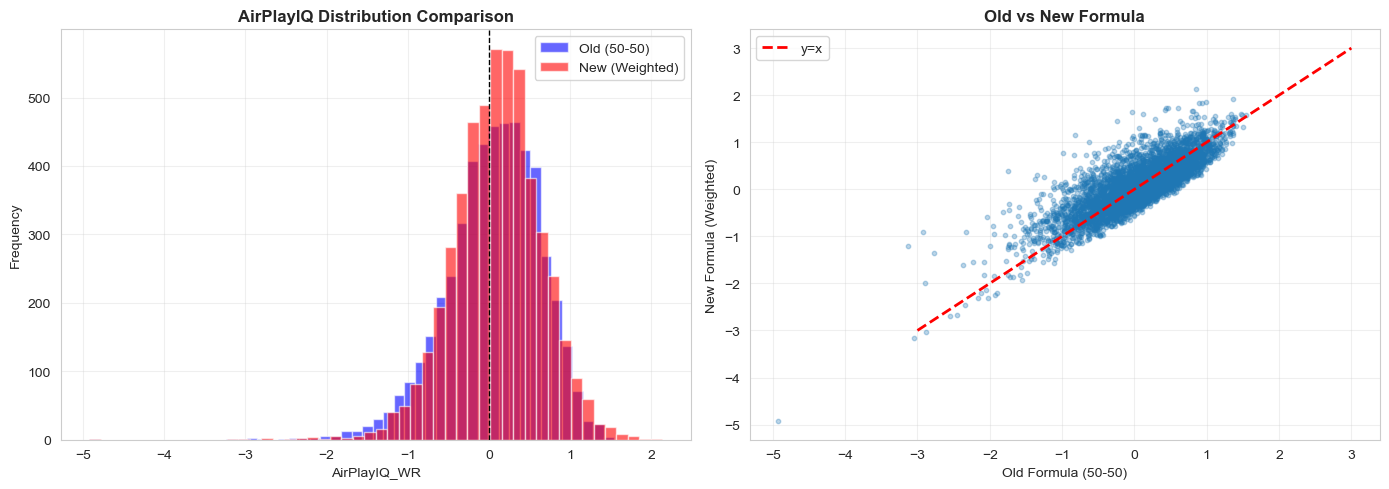

In [124]:
# Compare old vs new formula

print("FORMULA COMPARISON")


# Calculate old formula for comparison
df_metrics['AirPlayIQ_WR_Old'] = (
    0.5 * df_metrics['RouteExecIQ'] + 
    0.5 * df_metrics['ConvergenceIQ_WR']
)

# Show differences for key players
print("Impact on Key Players (Old vs New Formula):")


key_players = ['Tyreek Hill', 'Davante Adams', "Ja'Marr Chase"]
comparison = df_metrics[
    df_metrics['player_name'].isin(key_players)
].groupby('player_name').agg({
    'RouteExecIQ': 'mean',
    'ConvergenceIQ_WR': 'mean',
    'AirPlayIQ_WR_Old': 'mean',
    'AirPlayIQ_WR': 'mean',
    'RouteExec_Weight': 'mean'
}).round(3)

comparison['Difference'] = (comparison['AirPlayIQ_WR'] - comparison['AirPlayIQ_WR_Old']).round(3)
comparison = comparison.sort_values('Difference', ascending=False)

print(comparison)

# Overall distribution comparison

print("Overall Distribution:")
print(f"Old Formula - Mean: {df_metrics['AirPlayIQ_WR_Old'].mean():.3f}, Std: {df_metrics['AirPlayIQ_WR_Old'].std():.3f}")
print(f"New Formula - Mean: {df_metrics['AirPlayIQ_WR'].mean():.3f}, Std: {df_metrics['AirPlayIQ_WR'].std():.3f}")
print(f"Correlation: {df_metrics[['AirPlayIQ_WR_Old', 'AirPlayIQ_WR']].corr().iloc[0,1]:.3f}")

# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution comparison
axes[0].hist(df_metrics['AirPlayIQ_WR_Old'].dropna(), bins=50, alpha=0.6, label='Old (50-50)', color='blue')
axes[0].hist(df_metrics['AirPlayIQ_WR'].dropna(), bins=50, alpha=0.6, label='New (Weighted)', color='red')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('AirPlayIQ Distribution Comparison', fontweight='bold')
axes[0].set_xlabel('AirPlayIQ_WR')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Scatter: Old vs New
axes[1].scatter(df_metrics['AirPlayIQ_WR_Old'], df_metrics['AirPlayIQ_WR'], alpha=0.3, s=10)
axes[1].plot([-3, 3], [-3, 3], 'r--', linewidth=2, label='y=x')
axes[1].set_title('Old vs New Formula', fontweight='bold')
axes[1].set_xlabel('Old Formula (50-50)')
axes[1].set_ylabel('New Formula (Weighted)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Step 3: Visualize All Three Metrics

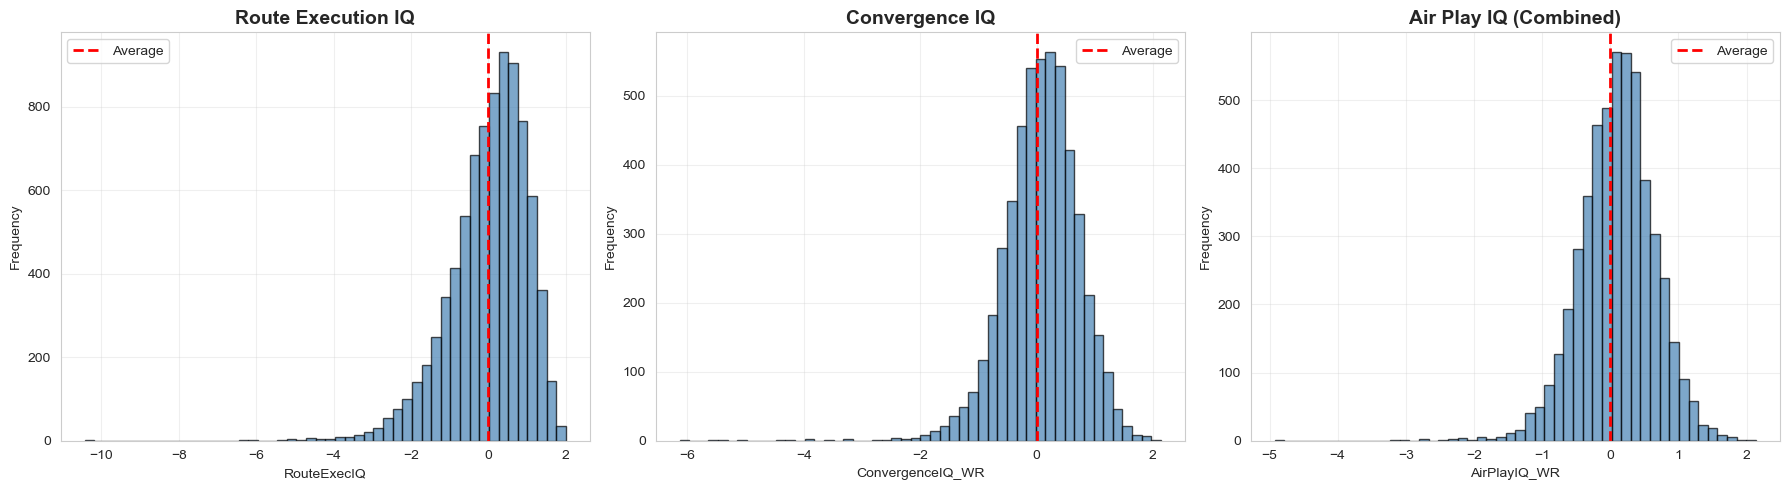

In [132]:
# Distribution of all three metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RouteExecIQ', 'ConvergenceIQ_WR', 'AirPlayIQ_WR']
titles = ['Route Execution IQ', 'Convergence IQ', 'Air Play IQ (Combined)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    axes[i].hist(df_metrics[metric].dropna(), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Average')
    axes[i].set_title(title, fontweight='bold', fontsize=14)
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4: Relationship Between Metrics

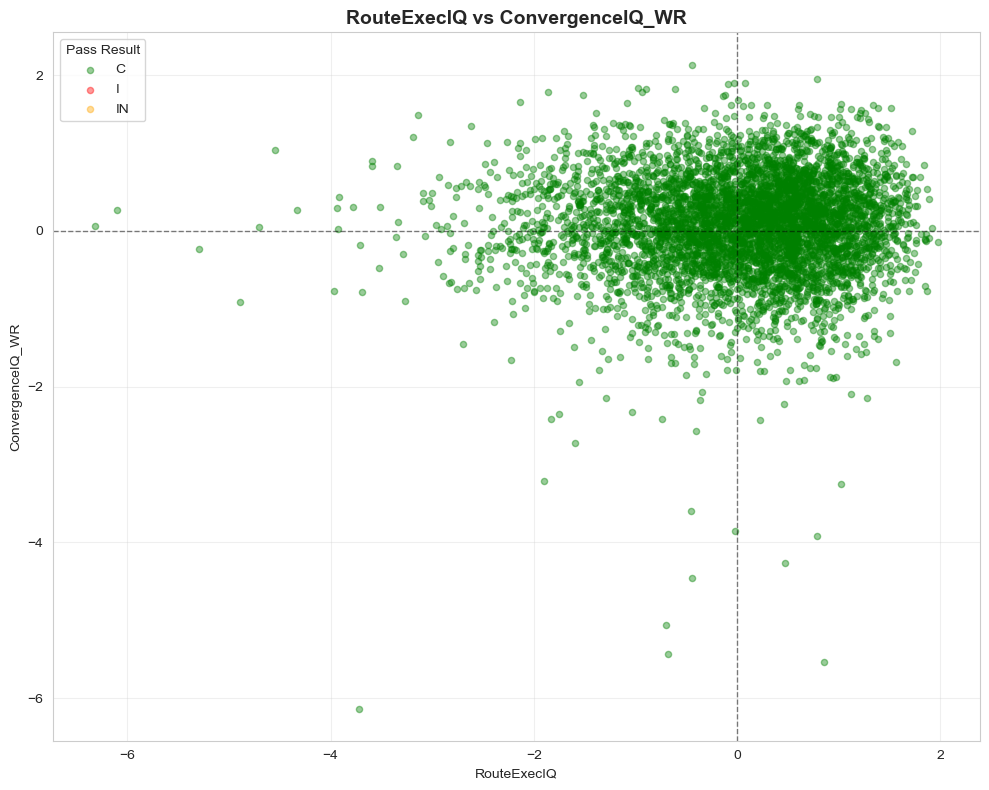


Correlation between RouteExecIQ and ConvergenceIQ_WR: 0.032


In [126]:
# Scatter plot: RouteExecIQ vs ConvergenceIQ
fig, ax = plt.subplots(figsize=(10, 8))

# Color by pass result
colors = {'C': 'green', 'I': 'red', 'IN': 'orange'}
for result in ['C', 'I', 'IN']:
    subset = df_metrics[df_metrics['pass_result'] == result]
    ax.scatter(
        subset['RouteExecIQ'], 
        subset['ConvergenceIQ_WR'],
        alpha=0.4,
        s=20,
        color=colors[result],
        label=result
    )

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('RouteExecIQ vs ConvergenceIQ_WR', fontweight='bold', fontsize=14)
ax.set_xlabel('RouteExecIQ')
ax.set_ylabel('ConvergenceIQ_WR')
ax.legend(title='Pass Result', loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation
corr = df_metrics[['RouteExecIQ', 'ConvergenceIQ_WR']].corr().iloc[0, 1]
print(f"\nCorrelation between RouteExecIQ and ConvergenceIQ_WR: {corr:.3f}")

### Step 5: Save Combined Metrics

In [127]:
# Save metrics to CSV
output_path = r"C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\air_play_iq_metrics_weighted.csv"
df_metrics.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")
print(f"  ✓ New filename preserves old CSV (air_play_iq_metrics_adjusted.csv)")
print(f"\nFinal metrics dataframe:")
print(f"  Shape: {df_metrics.shape}")
print(f"  Columns: {df_metrics.columns.tolist()}")

Metrics saved to: C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\air_play_iq_metrics_weighted.csv
  ✓ New filename preserves old CSV (air_play_iq_metrics_adjusted.csv)

Final metrics dataframe:
  Shape: (8202, 18)
  Columns: ['game_id', 'play_id', 'nfl_id', 'player_name', 'player_position', 'route_cluster', 'route_label', 'pass_result', 'yards_gained', 'route_deviation', 'RouteExecIQ', 'ConvergenceIQ_WR', 'num_frames', 'air_yards', 'AirPlayIQ_WR', 'RouteExec_Weight', 'Convergence_Weight', 'AirPlayIQ_WR_Old']


---

## 3.4 Outputs and Visualizations

Coach-friendly visualizations and explanations of the Air Play IQ metrics.

---

### Player Rankings by AirPlayIQ

In [128]:
player_stats_correct = df_metrics.groupby(['nfl_id', 'player_name']).agg({
    'AirPlayIQ_WR': 'mean',                     # The main score
    'game_id': 'count',                         # Volume (Routes Run)
    'pass_result': lambda x: (x == 'C').mean()  # Catch Rate
}).reset_index()

# Rename for clarity
player_stats_correct.rename(columns={'game_id': 'routes_run', 'pass_result': 'catch_rate'}, inplace=True)

# ---------------------------------------------------------
# 3. DYNAMIC VOLUME THRESHOLD
# ---------------------------------------------------------
# We dynamically set the filter to 50% of the max volume in the file.
# This ensures it works for any file size (1 week vs 17 weeks).
max_vol = player_stats_correct['routes_run'].max()
threshold = max_vol * 0.50

print(f"Max Volume: {max_vol} | Threshold: > {threshold:.0f} routes")

df_qualified = player_stats_correct[player_stats_correct['routes_run'] > threshold].copy()

# ---------------------------------------------------------
# 4. RANKING & DISPLAY
# ---------------------------------------------------------
df_qualified['Rank'] = df_qualified['AirPlayIQ_WR'].rank(ascending=False)

print("\n--- TOP 10 WRs (Best Separators) ---")
print(df_qualified.sort_values('Rank').head(10)[['Rank', 'player_name', 'routes_run', 'AirPlayIQ_WR', 'catch_rate']].to_string(index=False))

print("\n--- BOTTOM 10 WRs (Lowest Scores) ---")
print(df_qualified.sort_values('Rank').tail(10)[['Rank', 'player_name', 'routes_run', 'AirPlayIQ_WR', 'catch_rate']].to_string(index=False))

Max Volume: 158 | Threshold: > 79 routes

--- TOP 10 WRs (Best Separators) ---
 Rank      player_name  routes_run  AirPlayIQ_WR  catch_rate
  1.0       A.J. Brown         137      0.294057    0.729927
  2.0   Marquise Brown          81      0.292260    0.567901
  3.0     Nico Collins          85      0.246715    0.752941
  4.0      Chris Olave         118      0.238741    0.618644
  5.0    Ja'Marr Chase          97      0.176875    0.639175
  6.0 Courtland Sutton          80      0.176330    0.675000
  7.0    Jaylen Waddle          82      0.171403    0.670732
  8.0       DK Metcalf          95      0.164484    0.621053
  9.0    DeVonta Smith          90      0.162512    0.733333
 10.0      CeeDee Lamb         158      0.160874    0.753165

--- BOTTOM 10 WRs (Lowest Scores) ---
 Rank      player_name  routes_run  AirPlayIQ_WR  catch_rate
 25.0     Amari Cooper         112      0.073184    0.633929
 26.0     Stefon Diggs         122      0.039211    0.663934
 27.0 Chris Godwin Jr.      

### AirPlayIQ by Route Type

In [131]:
output_path = r"C:\Users\rajas\Documents\ADS\SII\Big_Data_Bowl\air_play_iq_metrics_weighted_filtered.csv"
df_qualified.to_csv(output_path, index=False)

In [129]:
# Analysis by route type
print("Analyzing metrics by route type...")

route_analysis = df_metrics.groupby('route_label')[[
    'RouteExecIQ', 'ConvergenceIQ_WR', 'AirPlayIQ_WR'
]].agg(['mean', 'std', 'count']).reset_index()

# Flatten
route_analysis.columns = [
    'route_label',
    'RouteExecIQ_mean', 'RouteExecIQ_std', 'RouteExecIQ_count',
    'ConvergenceIQ_mean', 'ConvergenceIQ_std', 'ConvergenceIQ_count',
    'AirPlayIQ_mean', 'AirPlayIQ_std', 'AirPlayIQ_count'
]

# Filter to routes with ≥50 plays
route_analysis = route_analysis[route_analysis['RouteExecIQ_count'] >= 50].sort_values('AirPlayIQ_mean', ascending=False)

print("\nAirPlayIQ by route type (routes with ≥50 plays):")
print(route_analysis[['route_label', 'RouteExecIQ_mean', 'ConvergenceIQ_mean', 'AirPlayIQ_mean', 'RouteExecIQ_count']].to_string(index=False))

Analyzing metrics by route type...

AirPlayIQ by route type (routes with ≥50 plays):
route_label  RouteExecIQ_mean  ConvergenceIQ_mean  AirPlayIQ_mean  RouteExecIQ_count
         IN          0.027454            0.333189        0.304977                855
      SLANT          0.181548            0.264370        0.279001                860
       POST         -0.111764            0.221148        0.195812                624
      CROSS         -0.215228            0.179333        0.166939                998
     CORNER          0.149755           -0.039466        0.025216                366
      HITCH          0.058251           -0.036984        0.015165               1888
         GO         -0.112926            0.013572        0.007178               1139
        OUT          0.049897           -0.054115       -0.007803               1438


### Metric Performance by Pass Result

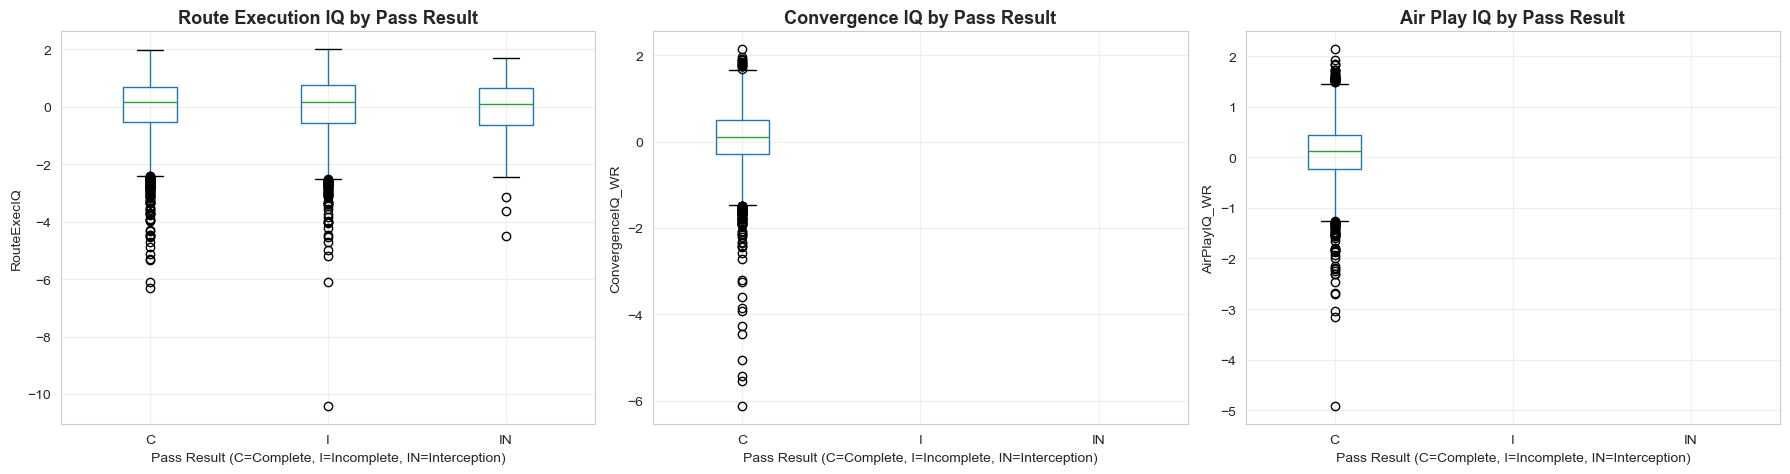


Metrics by pass result:

RouteExecIQ:
              mean    std
pass_result              
C            0.006  0.976
I           -0.008  1.041
IN          -0.042  1.011

ConvergenceIQ_WR:
              mean    std
pass_result              
C            0.079  0.648
I              NaN    NaN
IN             NaN    NaN

AirPlayIQ_WR:
             mean    std
pass_result             
C             0.1  0.548
I             NaN    NaN
IN            NaN    NaN


In [130]:
# Box plots by pass result
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['RouteExecIQ', 'ConvergenceIQ_WR', 'AirPlayIQ_WR']
titles = ['Route Execution IQ', 'Convergence IQ', 'Air Play IQ']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    df_metrics.boxplot(column=metric, by='pass_result', ax=axes[i])
    axes[i].set_title(f'{title} by Pass Result', fontweight='bold', fontsize=13)
    axes[i].set_xlabel('Pass Result (C=Complete, I=Incomplete, IN=Interception)')
    axes[i].set_ylabel(metric)
    axes[i].grid(alpha=0.3)

plt.suptitle('')  # Remove auto-title
plt.tight_layout()
plt.show()

# Print statistics
print("\nMetrics by pass result:")
for metric in metrics:
    print(f"\n{metric}:")
    print(df_metrics.groupby('pass_result')[metric].agg(['mean', 'std']).round(3))

---

## Coach-Friendly Narrative

### What Do These Metrics Mean?

We've created three complementary metrics to evaluate wide receiver performance on pass plays:

---

#### 1. **RouteExecIQ** (Pre-Throw Route Quality)

**What it measures**: How cleanly and efficiently the receiver ran their route before the ball was thrown.

**How it works**: 
- Compares the receiver's actual route to typical routes of that type (based on clustering)
- Lower deviation = cleaner route = higher IQ
- Accounts for route type (a GO route should look different from a HITCH)

**Interpretation**:
- **RouteExecIQ = +1.5**: Route was significantly cleaner than average
  - Fewer wasted steps
  - Better spacing and timing
  - More direct path to target depth/width
  
- **RouteExecIQ = -1.5**: Route had more deviation than average
  - Extra direction changes
  - Hesitation or rounded cuts
  - Inefficient path

**Example Use Case**: 
> "Receiver A consistently has RouteExecIQ > +1.0 on OUT routes - they're running them crisper than 84% of WRs. This creates better separation and timing with the QB."

---

#### 2. **ConvergenceIQ_WR** (Post-Throw Ball Tracking)

**What it measures**: How efficiently the receiver adjusted and moved toward the catch point after the ball was thrown.

**How it works**:
- Uses an LSTM model to predict expected convergence rate based on:
  - Route type just run
  - Depth of throw (air yards)
  - Current position and time
- Compares actual convergence to this baseline
- Positive = closed distance faster than expected

**Interpretation**:
- **ConvergenceIQ = +1.2**: Tracked ball better than expected
  - Quick reaction to ball in air
  - Efficient acceleration toward catch point
  - Good ball tracking skills
  
- **ConvergenceIQ = -1.2**: Slower convergence than expected
  - Late reaction or hesitation
  - Poor angle to ball
  - Slower closing speed

**Example Use Case**:
> "On deep balls (30+ air yards), Receiver B has ConvergenceIQ consistently above +0.8. They excel at tracking deep throws and accelerating under the ball."

---

#### 3. **AirPlayIQ_WR** (Overall Air Play Performance)

**What it measures**: Complete picture of the receiver's contribution to the pass play.

**How it works**:
- Combines RouteExecIQ (50%) and ConvergenceIQ (50%)
- Captures both route running AND ball tracking

**Interpretation**:
- **AirPlayIQ = +1.5**: Elite performance on this play
  - Both route and tracking were excellent
  - Created value through technique and adjustment
  
- **AirPlayIQ = 0.0**: Average performance
  - Typical execution for that situation
  
- **AirPlayIQ = -1.5**: Below-average performance
  - Issues in route running, tracking, or both

**Example Use Case**:
> "Receiver C has avg AirPlayIQ of +0.9 on third downs - they elevate their performance in critical situations through both crisp routes and smart ball tracking."

---

### How Teams Can Use These Metrics

#### 1. **Player Evaluation**
- Identify receivers who excel at route running vs. ball tracking
- Find specialists (e.g., great on deep balls vs. short routes)
- Track development over time

#### 2.  **Play Design**
- Call route types that match receiver strengths (high RouteExecIQ)
- Use depth ranges where receiver tracks ball best (high ConvergenceIQ)
- Avoid mismatches (don't ask receiver to do what they don't do well)

#### 3. **Opponent Scouting**
- Identify tendencies in opponent WR performance
- Predict likely outcomes based on historical IQ scores
- Game plan for opponent strengths/weaknesses

#### 4. **QB-WR Chemistry**
- Compare metrics with different QBs
- See if certain QB-WR pairings perform better
- Identify timing/anticipation issues

---

### Key Findings from This Dataset

Based on our analysis:

1. **Completed passes** have higher average IQ scores across all three metrics
   - Suggests metrics capture real performance differences
   
2. **Route type matters**: Some routes naturally have tighter execution (HITCHes) vs. more variation (POST routes)

3. **RouteExecIQ and ConvergenceIQ are weakly correlated**
   - Being good at route running doesn't automatically mean good at tracking
   - These are distinct skills worth measuring separately

4. **Top performers** excel in BOTH components
   - Elite WRs combine technical route running with smart ball tracking

---

## Summary

✅ **RouteExecIQ**: Measures route quality (cluster-based deviation)

✅ **ConvergenceIQ_WR**: Measures ball tracking efficiency (LSTM residual-based)

✅ **AirPlayIQ_WR**: Combined metric (50/50 weighted average)

All metrics saved to: `air_play_iq_metrics.csv`

**Ready for coaching analysis and decision-making!**

---